In [1]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

# 2. Load Dataset
# Make sure to download the Telco Customer Churn dataset from Kaggle
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Quick look
print(df.shape)
print(df.info())
df.head()


(7043, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [2]:
# 3. Handle Missing Values
print(df.isnull().sum())

# 'TotalCharges' sometimes has spaces instead of numbers
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

# Drop duplicates if any
df = df.drop_duplicates()

# 4. Encode Target Variable
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# 5. Convert Tenure into categorical groups (optional, useful for insights)
def tenure_group(tenure):
    if tenure <= 12:
        return '0-1 year'
    elif tenure <= 24:
        return '1-2 years'
    elif tenure <= 36:
        return '2-3 years'
    elif tenure <= 48:
        return '3-4 years'
    elif tenure <= 60:
        return '4-5 years'
    else:
        return '5+ years'

df['TenureGroup'] = df['tenure'].apply(tenure_group)


customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


Overall Churn Rate: 26.54%


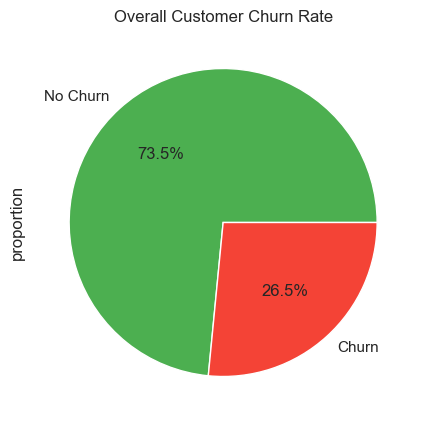

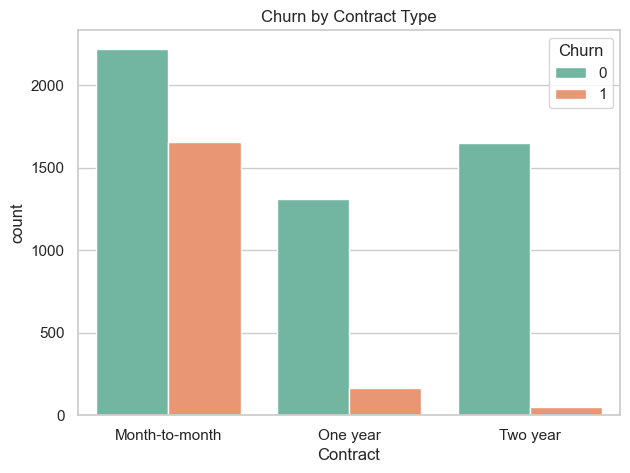

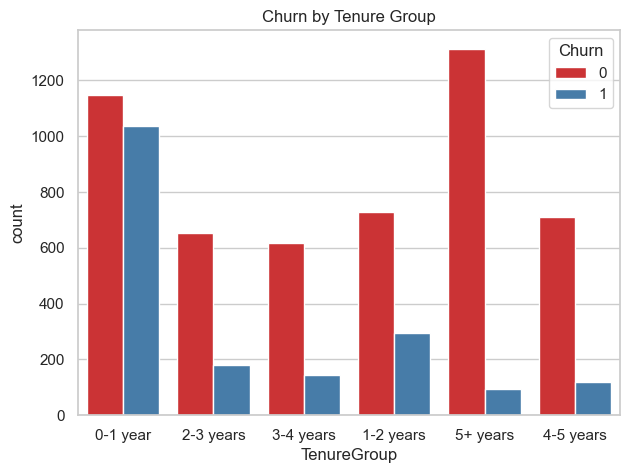

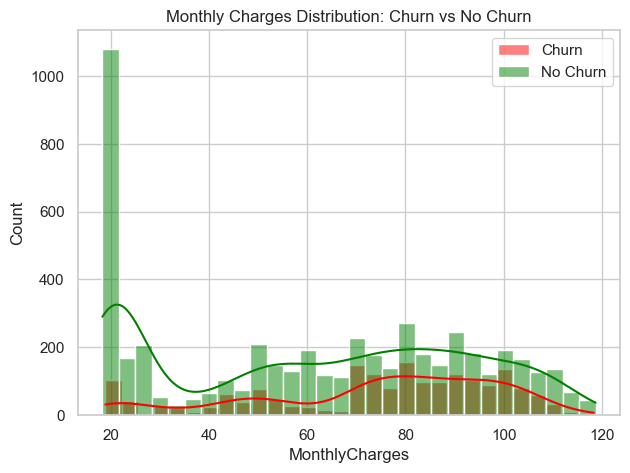

In [3]:
# 6. Overall Churn Rate
churn_rate = df['Churn'].mean()
print("Overall Churn Rate: {:.2f}%".format(churn_rate * 100))

plt.figure(figsize=(5,5))
df['Churn'].value_counts(normalize=True).plot.pie(autopct='%1.1f%%', labels=['No Churn','Churn'], colors=['#4CAF50','#F44336'])
plt.title("Overall Customer Churn Rate")
plt.show()

# 7. Churn by Contract Type
plt.figure(figsize=(7,5))
sns.countplot(data=df, x='Contract', hue='Churn', palette='Set2')
plt.title("Churn by Contract Type")
plt.show()

# 8. Churn by Tenure Group
plt.figure(figsize=(7,5))
sns.countplot(data=df, x='TenureGroup', hue='Churn', palette='Set1')
plt.title("Churn by Tenure Group")
plt.show()

# 9. Churn by Monthly Charges
plt.figure(figsize=(7,5))
sns.histplot(df[df['Churn']==1]['MonthlyCharges'], bins=30, color='red', label='Churn', kde=True)
sns.histplot(df[df['Churn']==0]['MonthlyCharges'], bins=30, color='green', label='No Churn', kde=True)
plt.legend()
plt.title("Monthly Charges Distribution: Churn vs No Churn")
plt.show()


In [6]:
# 1. Import ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb


In [7]:
# Separate categorical and numerical columns
cat_cols = df.select_dtypes(include=['object']).columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop(['Churn'])

# Encode categorical features
df_encoded = df.copy()
for col in cat_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])

# Features (X) and Target (y)
X = df_encoded.drop(['customerID', 'Churn'], axis=1)
y = df_encoded['Churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numerical features
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])


In [8]:
#Logistic Regression (Baseline Model)
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

print("Logistic Regression Results")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, log_reg.predict_proba(X_test)[:,1]))


Logistic Regression Results
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.65      0.56      0.60       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.80      0.80      0.80      1409

ROC-AUC: 0.8435867627683484


In [9]:
#Random Forest Classifier
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Results")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))


Random Forest Results
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.63      0.49      0.55       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409

ROC-AUC: 0.8262639179518976


In [10]:
#XGBoost Classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost Results")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:,1]))


C:\Users\ayoub\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\training.py:183: UserWarning: [11:16:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Results
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1035
           1       0.60      0.52      0.55       374

    accuracy                           0.78      1409
   macro avg       0.71      0.69      0.70      1409
weighted avg       0.77      0.78      0.77      1409

ROC-AUC: 0.8185396161099487


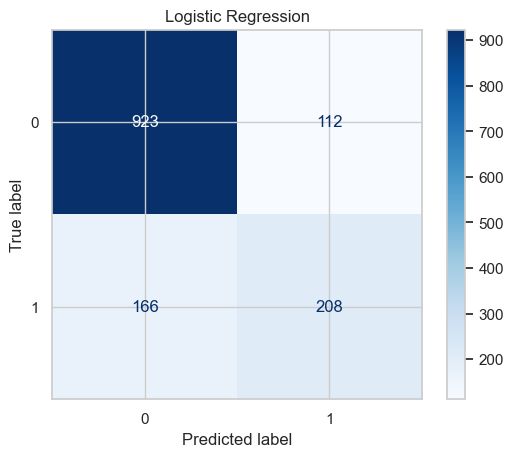

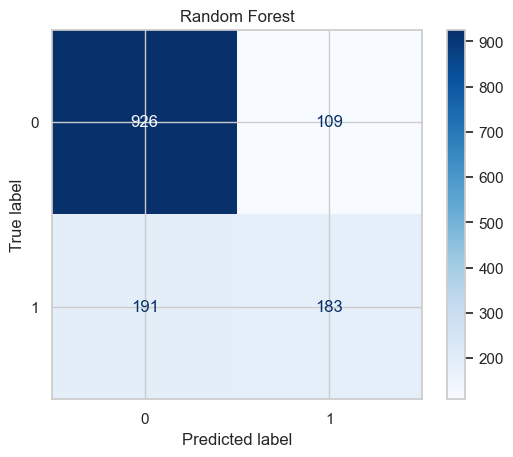

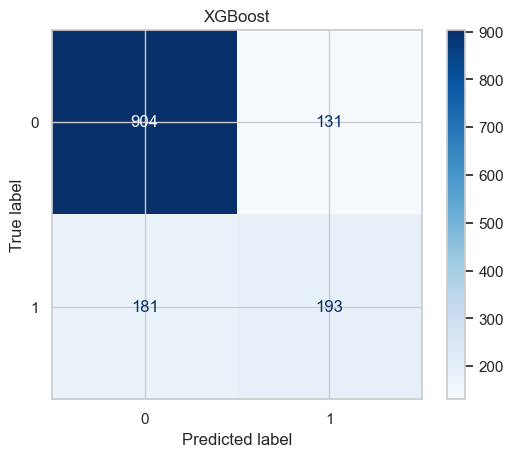

In [11]:
#Confusion Matrix Function (for visual clarity)
from sklearn.metrics import ConfusionMatrixDisplay

def plot_conf_matrix(model, X_test, y_test, title):
    disp = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues', values_format='d')
    plt.title(title)
    plt.show()

plot_conf_matrix(log_reg, X_test, y_test, "Logistic Regression")
plot_conf_matrix(rf, X_test, y_test, "Random Forest")
plot_conf_matrix(xgb_model, X_test, y_test, "XGBoost")


C:\Users\ayoub\AppData\Local\Temp\ipykernel_20356\3900261286.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feat_importances.head(15), palette="viridis")


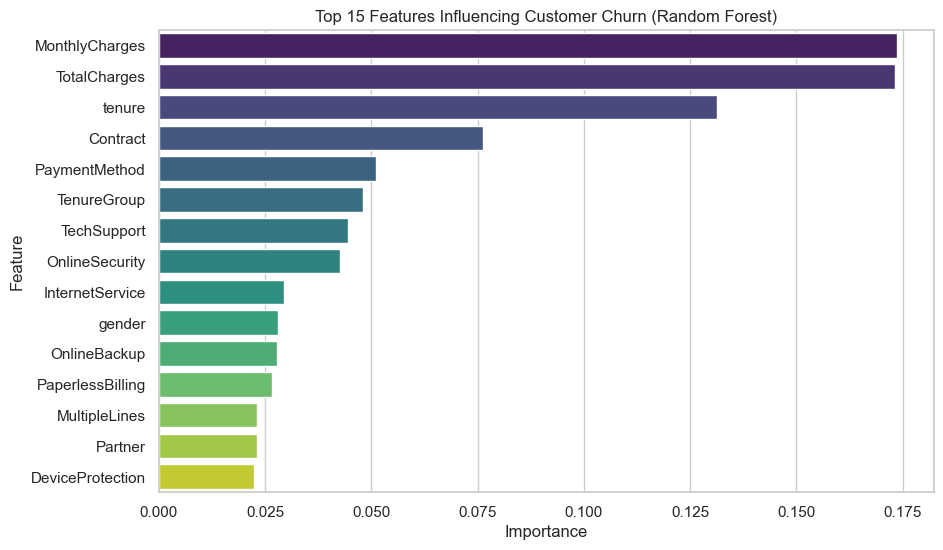

In [12]:
import seaborn as sns
import numpy as np

# --- 1. Feature Importance: Random Forest ---
importances = rf.feature_importances_
feature_names = X.columns
feat_importances = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feat_importances = feat_importances.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=feat_importances.head(15), palette="viridis")
plt.title("Top 15 Features Influencing Customer Churn (Random Forest)")
plt.show()


C:\Users\ayoub\AppData\Local\Temp\ipykernel_20356\1184683866.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feat_importances_xgb.head(15), palette="magma")


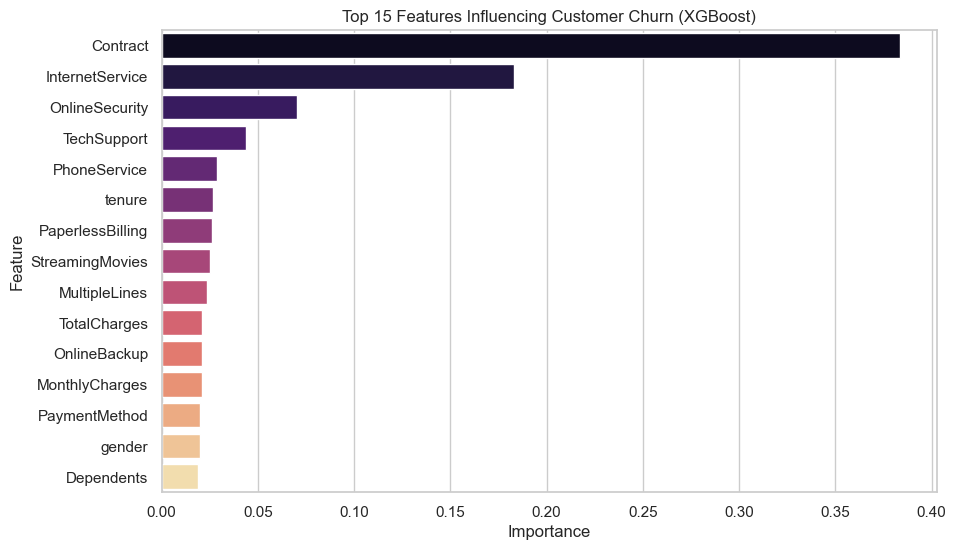

In [13]:
# --- 2. Feature Importance: XGBoost ---
xgb_importances = xgb_model.feature_importances_
feat_importances_xgb = pd.DataFrame({"Feature": feature_names, "Importance": xgb_importances})
feat_importances_xgb = feat_importances_xgb.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=feat_importances_xgb.head(15), palette="magma")
plt.title("Top 15 Features Influencing Customer Churn (XGBoost)")
plt.show()


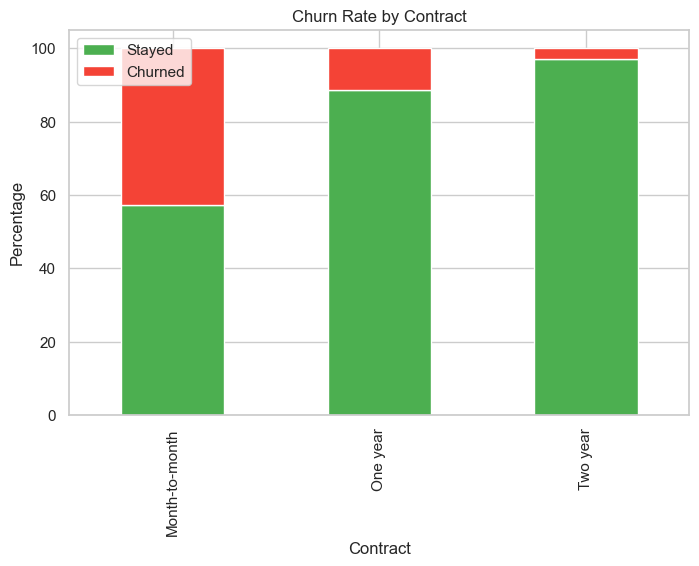

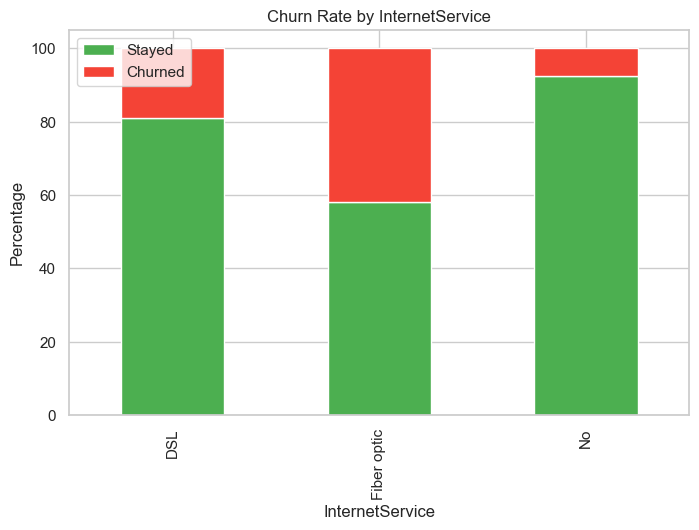

In [14]:
# --- 3. Churn Rate by Key Features ---
def churn_rate_by_feature(feature):
    churn_rates = df.groupby(feature)['Churn'].value_counts(normalize=True).unstack().fillna(0) * 100
    churn_rates.plot(kind='bar', stacked=True, figsize=(8,5), color=["#4CAF50", "#F44336"])
    plt.title(f"Churn Rate by {feature}")
    plt.ylabel("Percentage")
    plt.legend(["Stayed", "Churned"])
    plt.show()

# Example: check churn by contract type & tenure group
churn_rate_by_feature("Contract")
churn_rate_by_feature("InternetService")
